# Bias-variance tradeoff



In [86]:
#Loading data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Set plot style
try:
    plt.style.use('seaborn-whitegrid')  # For older matplotlib versions
except:
    try:
        plt.style.use('seaborn-v0_8-whitegrid')  # For newer matplotlib versions
    except:
        pass  # Fall back to default style if neither works

# Define the data
data = {
    'Quizzes': [5.3, 5.5, 5.5, 5.0, 2.5, 3.0, 3.0, 3.1, 3.5, 3.5, 3.7, 4.0, 4.0, 4.0, 4.0, 5.7],
    'Labs': [5.3, 5.9, 5.29, 4.35, 5.5, 5.0, 4.0, 3.1, 4.5, 5.62, 5.0, 3.0, 4.0, 5.75, 4.44, 5.9],
    'Final': [4.818, 5.773, 4.464, 5.069, 4.164, 4.091, 3.727, 3.909, 3.518, 4.897, 5.209, 3.0, 3.091, 5.818, 4.069, 5.77]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Display the original data
print("Original data shape:", df.shape)
df.head()

Original data shape: (16, 3)


,Quizzes,Labs,Final
0,5.3,5.30,4.818
1,5.5,5.90,5.773
2,5.5,5.29,4.464
3,5.0,4.35,5.069
4,2.5,5.50,4.164


Data augmentation

In [87]:
# replicating and adding noise
np.random.seed(42)
augmented = []
for i in range(len(df)):
    row = df.iloc[i]
    for _ in range(10):  # Create 10 variations of each record
        noise = np.random.normal(0, 0.2, 3)  # Add Gaussian noise with mean=0 and std=0.2
        new_row = row + noise
        # Ensure values are within boundaries (grades must be between 2 and 6)
        new_row = new_row.clip(2, 6)
        augmented.append(new_row)

# Create augmented DataFrame
df_aug = pd.DataFrame(augmented, columns=df.columns)

# Display the augmented data
print("Augmented data shape:", df_aug.shape)
df_aug.describe()

Augmented data shape: (160, 3)


,Quizzes,Labs,Final
count,160.000000,160.000000,160.000000
mean,4.091316,4.762389,4.479292
std,0.984321,0.904538,0.918909
min,2.219630,2.710383,2.718507
25%,3.335569,4.189950,3.808585
50%,3.861450,4.951766,4.432312
75%,5.090206,5.491895,5.229416
max,6.000000,6.000000,6.000000


# Bias-variance tradeoff

We now will sample multiple times from the augmented dataset. With each sampling, we will create another model. We will try this for several polynomial degrees (each separately). The models from the different samplings will be averaged in one final model. The variance resulting from the different samplings adds up as the variance component of the model error. And the bias is calculated as the averaged deviation between predictions from the averaged (blue) model, and the real data labels.

```
    bias_squared = np.mean((avg_test_predictions - y_test.values) ** 2)
```

The variance component in the code measures how much model predictions fluctuate across different training samples for the same input. Here's how it's calculated:

```
    variance = np.mean(np.var(all_test_predictions, axis=0))
   
```
The code trains multiple models (typically 10) using different random samples of the training data (bootstrap sampling).
For each input point (from the test set), predictions from all models are collected. For each test point, the variance of predictions across all models is collected. This is how we can plot the variance as a function of the value of each test input. The mean of these pointwise variances gives the overall variance measure.

The total error is given by the bias and variance (as well as the irreducible noise present in the data, estimated from training data). 
```
    total_error = bias_squared + variance
```
We will now create different functions to visualize bias and variance. Run the following three cells and go over the code and comments.


In [88]:
# Create a function to visualize bias-variance tradeoff with multiple models
def visualize_bias_variance(df_aug, degrees=[1, 2, 10], num_samples=10, test_size=0.3):
    """
    Visualize bias-variance tradeoff for polynomial models of different degrees.
    
    Parameters:
    - df_aug: Augmented DataFrame containing the features and target
    - degrees: List of polynomial degrees to evaluate
    - num_samples: Number of different training samples to use
    - test_size: Proportion of data to use for testing
    """
    # Use Labs as the feature variable and Final as the target
    X = df_aug[['Labs']]
    y = df_aug['Final']
    
    # Create a common test set
    X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    # Create figure with subplots
    fig, axes = plt.subplots(1, len(degrees), figsize=(18, 6))
    
    # Create a grid of x values for plotting smooth curves
    x_grid = np.linspace(2, 6, 100).reshape(-1, 1)
    
    # Summary table data
    summary_data = []
    
    # Process each degree
    for i, degree in enumerate(degrees):
        ax = axes[i]
        ax.set_title(f'Polynomial Degree {degree}', fontsize=14)
        ax.set_xlabel('Labs', fontsize=12)
        ax.set_ylabel('Final Grade', fontsize=12)
        
        # Store all predictions for calculating bias and variance
        all_predictions = np.zeros((num_samples, len(x_grid)))
        all_test_predictions = np.zeros((num_samples, len(X_test)))
        
        # Train multiple models with different samplings
        for j in range(num_samples):
            # Sample from training data with replacement
            indices = np.random.choice(len(X_train_full), size=len(X_train_full), replace=True)
            X_sample = X_train_full.iloc[indices]
            y_sample = y_train_full.iloc[indices]
            
            # Create and train model
            model = make_pipeline(
                PolynomialFeatures(degree=degree),
                LinearRegression()
            )
            model.fit(X_sample, y_sample)
            
            # Predict on grid for smooth visualization
            predictions = model.predict(x_grid)
            all_predictions[j] = predictions
            
            # Predict on test data for metrics calculation
            test_pred = model.predict(X_test)
            all_test_predictions[j] = test_pred
            
            # Plot this model's predictions (light gray line)
            ax.plot(x_grid, predictions, color='lightgray', alpha=0.5, linewidth=0.8)
        
        # Calculate average predictions for grid and test data
        avg_grid_predictions = np.mean(all_predictions, axis=0)
        avg_test_predictions = np.mean(all_test_predictions, axis=0)
        
        # Plot average model prediction (thick blue line)
        ax.plot(x_grid, avg_grid_predictions, color='blue', linewidth=2.5, label='Average Model')
        
        # Plot test data points
        ax.scatter(X_test, y_test, color='red', s=20, alpha=0.6, label='Test Points')
        
        # Set axis limits to be between 2 and 6
        ax.set_xlim(2, 6)
        ax.set_ylim(2, 6)
        
        # Calculate bias^2 (how far the average prediction is from the true values)
        bias_squared = np.mean((avg_test_predictions - y_test.values) ** 2)
        
        # Calculate variance (how much individual predictions vary)
        variance = np.mean(np.var(all_test_predictions, axis=0))
        
        # Calculate total error (MSE = bias^2 + variance)
        total_error = bias_squared + variance
        
        # Add metrics to plot
        ax.text(0.05, 0.95, f'Bias²: {bias_squared:.4f}', transform=ax.transAxes, 
                fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
        ax.text(0.05, 0.87, f'Variance: {variance:.4f}', transform=ax.transAxes, 
                fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
        ax.text(0.05, 0.79, f'Total Error: {total_error:.4f}', transform=ax.transAxes, 
                fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
        
        # Add legend
        if i == len(degrees) - 1:
            ax.legend(loc='lower right')
            
        # Store metrics for summary
        summary_data.append({
            'degree': degree,
            'bias_squared': bias_squared,
            'variance': variance,
            'total_error': total_error
        })
    
    plt.tight_layout()
    plt.suptitle('Bias-Variance Tradeoff for Polynomial Models (Labs vs Final)', fontsize=16, y=1.05)
    
    # Return the plot and summary data
    return fig, axes, summary_data

In [79]:
# Plot bias-variance tradeoff curve across all degrees
def plot_bias_variance_curve(df_aug, max_degree=10, num_samples=10, test_size=0.3):
    """
    Plot bias and variance as a function of model complexity.
    
    Parameters:
    - df_aug: Augmented DataFrame containing the features and target
    - max_degree: Maximum polynomial degree to evaluate
    - num_samples: Number of different training samples to use
    - test_size: Proportion of data to use for testing
    """
    # Use Labs as feature
    X = df_aug[['Labs']]
    y = df_aug['Final']
    
    # Create a common test set
    X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    # Arrays to store results
    degrees = list(range(1, max_degree + 1))
    bias_values = []
    variance_values = []
    total_error_values = []
    
    # Calculate metrics for each degree
    for degree in degrees:
        # Store predictions for all samples
        all_test_predictions = np.zeros((num_samples, len(X_test)))
        
        # Train multiple models with different samplings
        for j in range(num_samples):
            # Sample from training data with replacement
            indices = np.random.choice(len(X_train_full), size=len(X_train_full), replace=True)
            X_sample = X_train_full.iloc[indices]
            y_sample = y_train_full.iloc[indices]
            
            # Create and train model
            model = make_pipeline(
                PolynomialFeatures(degree=degree),
                LinearRegression()
            )
            model.fit(X_sample, y_sample)
            
            # Predict on test data
            test_pred = model.predict(X_test)
            all_test_predictions[j] = test_pred
            
        # Calculate average predictions
        avg_test_predictions = np.mean(all_test_predictions, axis=0)
        
        # Calculate bias^2
        bias_squared = np.mean((avg_test_predictions - y_test.values) ** 2)
        bias_values.append(bias_squared)
        
        # Calculate variance
        variance = np.mean(np.var(all_test_predictions, axis=0))
        variance_values.append(variance)
        
        # Calculate total error
        total_error = bias_squared + variance
        total_error_values.append(total_error)
    
    # Create plot
    plt.figure(figsize=(10, 6))
    plt.plot(degrees, bias_values, 'o-', color='blue', linewidth=2, label='Bias²')
    plt.plot(degrees, variance_values, 'o-', color='green', linewidth=2, label='Variance')
    plt.plot(degrees, total_error_values, 'o-', color='red', linewidth=2, label='Total Error')
    
    # Highlight specific degrees
    highlight_degrees = [1, 3, 10]
    for deg in highlight_degrees:
        idx = deg - 1
        plt.scatter(deg, bias_values[idx], color='blue', s=100, zorder=5)
        plt.scatter(deg, variance_values[idx], color='green', s=100, zorder=5)
        plt.scatter(deg, total_error_values[idx], color='red', s=100, zorder=5)
    
    plt.xlabel('Polynomial Degree (Model Complexity)', fontsize=14)
    plt.ylabel('Error', fontsize=14)
    plt.title('Bias-Variance Tradeoff with Increasing Model Complexity (Labs vs Final)', fontsize=16)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)
    
    # Set y-axis limit to a reasonable value based on data
    max_error = max(max(bias_values), max(variance_values), max(total_error_values))
    plt.ylim(0, min(max_error * 1.1, 2.0))  # Cap at 2.0 to keep visualization clean
    
    return plt.gcf()

In [89]:
# Function to visualize bias and variance as a function of data values
def visualize_error_components_by_x(df_aug, degrees=[1, 3, 10], num_samples=10, test_size=0.3, noise_var=0.04):
    """
    Visualize how bias, variance, noise, and total error vary across the input space.
    
    Parameters:
    - df_aug: Augmented DataFrame containing the features and target
    - degrees: List of polynomial degrees to evaluate
    - num_samples: Number of different training samples to use
    - test_size: Proportion of data to use for testing
    - noise_var: Estimated noise variance in the data
    """
    # Use Labs as the feature
    X = df_aug[['Labs']]
    y = df_aug['Final']
    
    # Create a common test set
    X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    # Create a fine grid of x values for evaluation
    x_grid = np.linspace(2, 6, 100).reshape(-1, 1)
    
    # Create figure with subplots
    fig, axes = plt.subplots(1, len(degrees), figsize=(18, 6))
    
    # Color mapping for error components
    colors = {'Bias²': 'blue', 'Variance': 'green', 'Noise': 'gray', 'Total Error': 'red'}
    
    # Process each degree
    for i, degree in enumerate(degrees):
        ax = axes[i]
        ax.set_title(f'Error Components - Degree {degree}', fontsize=14)
        ax.set_xlabel('Labs', fontsize=12)
        ax.set_ylabel('Error Component Value', fontsize=12)
        
        # Store predictions for all samples at each grid point
        all_grid_predictions = np.zeros((num_samples, len(x_grid)))
        
        # Train multiple models with different samplings
        for j in range(num_samples):
            # Sample from training data with replacement
            indices = np.random.choice(len(X_train_full), size=len(X_train_full), replace=True)
            X_sample = X_train_full.iloc[indices]
            y_sample = y_train_full.iloc[indices]
            
            # Create and train model
            model = make_pipeline(
                PolynomialFeatures(degree=degree),
                LinearRegression()
            )
            model.fit(X_sample, y_sample)
            
            # Predict on grid
            grid_pred = model.predict(x_grid)
            all_grid_predictions[j] = grid_pred
        
        # Calculate average prediction at each grid point
        avg_grid_predictions = np.mean(all_grid_predictions, axis=0)
        
        # Calculate expected true values at grid points (using a high-degree polynomial fit on all data)
        true_model = make_pipeline(
            PolynomialFeatures(degree=min(15, len(df_aug) // 5)),  # Higher degree but avoid overfitting
            LinearRegression()
        )
        true_model.fit(X, y)
        expected_true_values = true_model.predict(x_grid)
        
        # Calculate error components at each grid point
        bias_squared = (avg_grid_predictions - expected_true_values) ** 2
        variance = np.var(all_grid_predictions, axis=0)
        noise = np.ones_like(x_grid.flatten()) * noise_var  # Constant noise assumption
        total_error = bias_squared + variance + noise
        
        # Plot each error component
        ax.plot(x_grid, bias_squared, color=colors['Bias²'], linewidth=2, label='Bias²')
        ax.plot(x_grid, variance, color=colors['Variance'], linewidth=2, label='Variance')
        ax.plot(x_grid, noise, color=colors['Noise'], linewidth=2, label='Noise')
        ax.plot(x_grid, total_error, color=colors['Total Error'], linewidth=2, label='Total Error')
        
        # Set axis limits
        ax.set_xlim(2, 6)
        ax.set_ylim(0, min(np.max(total_error) * 1.1, 1.0))  # Cap at 1.0 for clarity
        
        # Add legend
        if i == len(degrees) - 1:
            ax.legend(loc='best')
        
    plt.tight_layout()
    plt.suptitle('Error Components Across Input Space (X = Labs)', fontsize=16, y=1.05)
    
    return fig, axes

Now we will get some plots.


Bias-Variance Decomposition Summary (Labs vs Final):
Degree    Bias²               Variance            Total Error         
------------------------------------------------------------
1         0.3148              0.0099              0.3247              
2         0.3040              0.0038              0.3078              
10        0.2942              0.0619              0.3561              
Saved figure as 'bias_variance_models_labs.png'


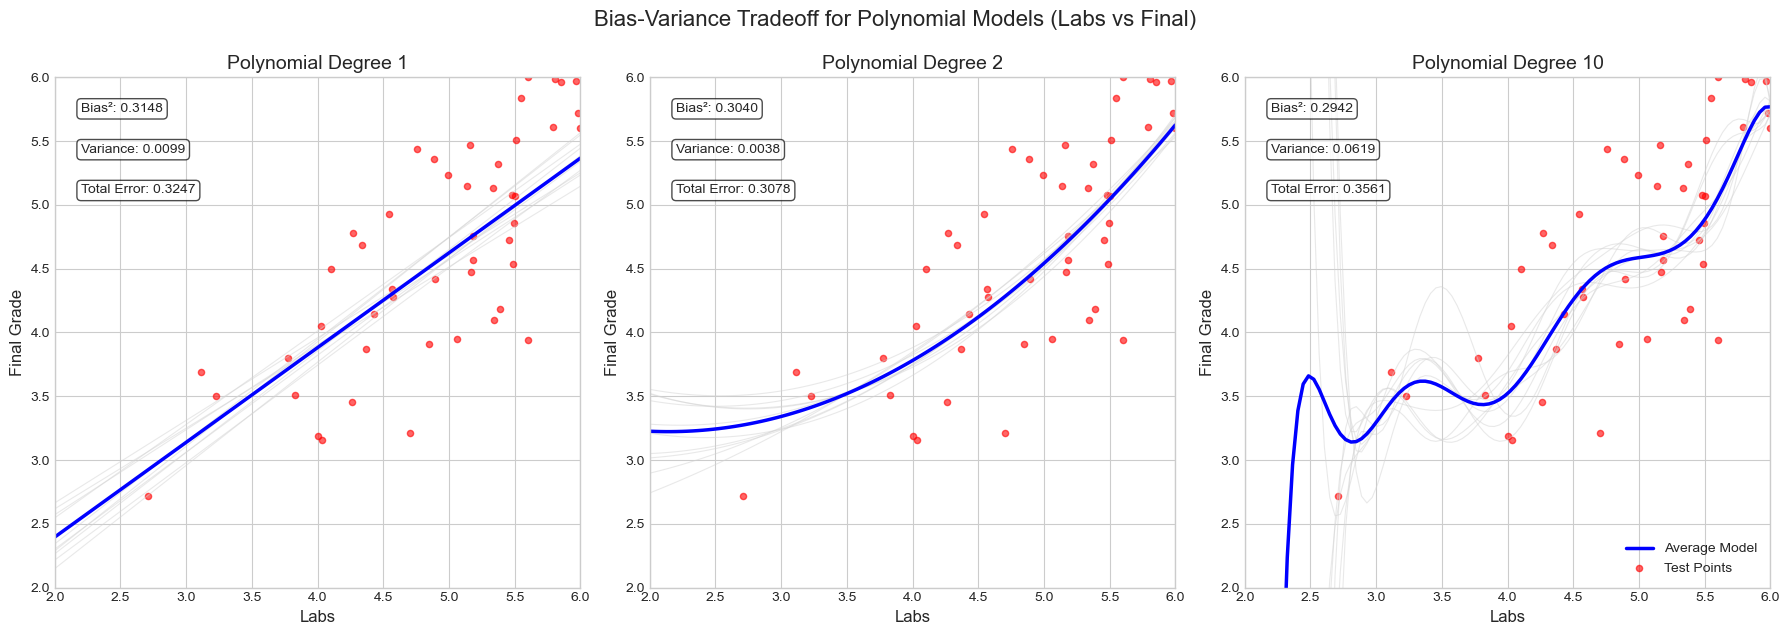

In [90]:
# Generate the specific degree visualizations using Labs as the input
%matplotlib inline
fig1, axes, summary = visualize_bias_variance(df_aug, degrees=[1, 2, 10], num_samples=10)

# Print summary table
print("\nBias-Variance Decomposition Summary (Labs vs Final):")
print("=" * 60)
print(f"{'Degree':<10}{'Bias²':<20}{'Variance':<20}{'Total Error':<20}")
print("-" * 60)
for item in summary:
    print(f"{item['degree']:<10}{item['bias_squared']:<20.4f}{item['variance']:<20.4f}{item['total_error']:<20.4f}")

# Save figure
fig1.savefig('bias_variance_models_labs.png', dpi=300, bbox_inches='tight')
print("Saved figure as 'bias_variance_models_labs.png'")

On the plots above the different models reasulting from each separate sampling of the training data are shown in light gray. The averaged model is shown in blue. The boas, variance, and total error, averaged from the individual values for each test data sample, are shown on the plots for each polynomial degree.

Saved figure as 'bias_variance_curve_labs.png'


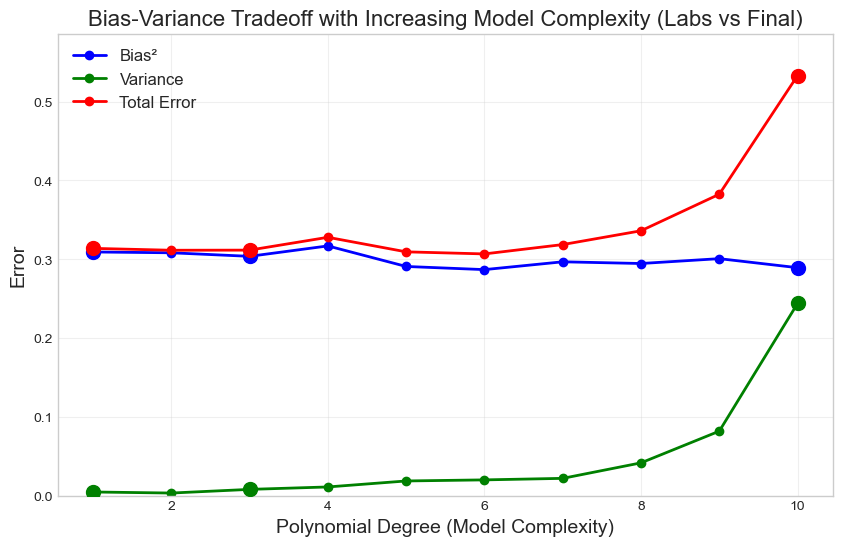

In [91]:
# Generate the bias-variance curve for all polyniomial degrees
%matplotlib inline
fig2 = plot_bias_variance_curve(df_aug, max_degree=10, num_samples=10)

# Save figure
fig2.savefig('bias_variance_curve_labs.png', dpi=300, bbox_inches='tight')
print("Saved figure as 'bias_variance_curve_labs.png'")

The plot above shows the averaged bias and variance over all test data samples (as well as the total error resulting from adding them), for each polynomial degree. Notice how the variance grows with the polynomial degree.

Saved figure as 'error_components_labs.png'


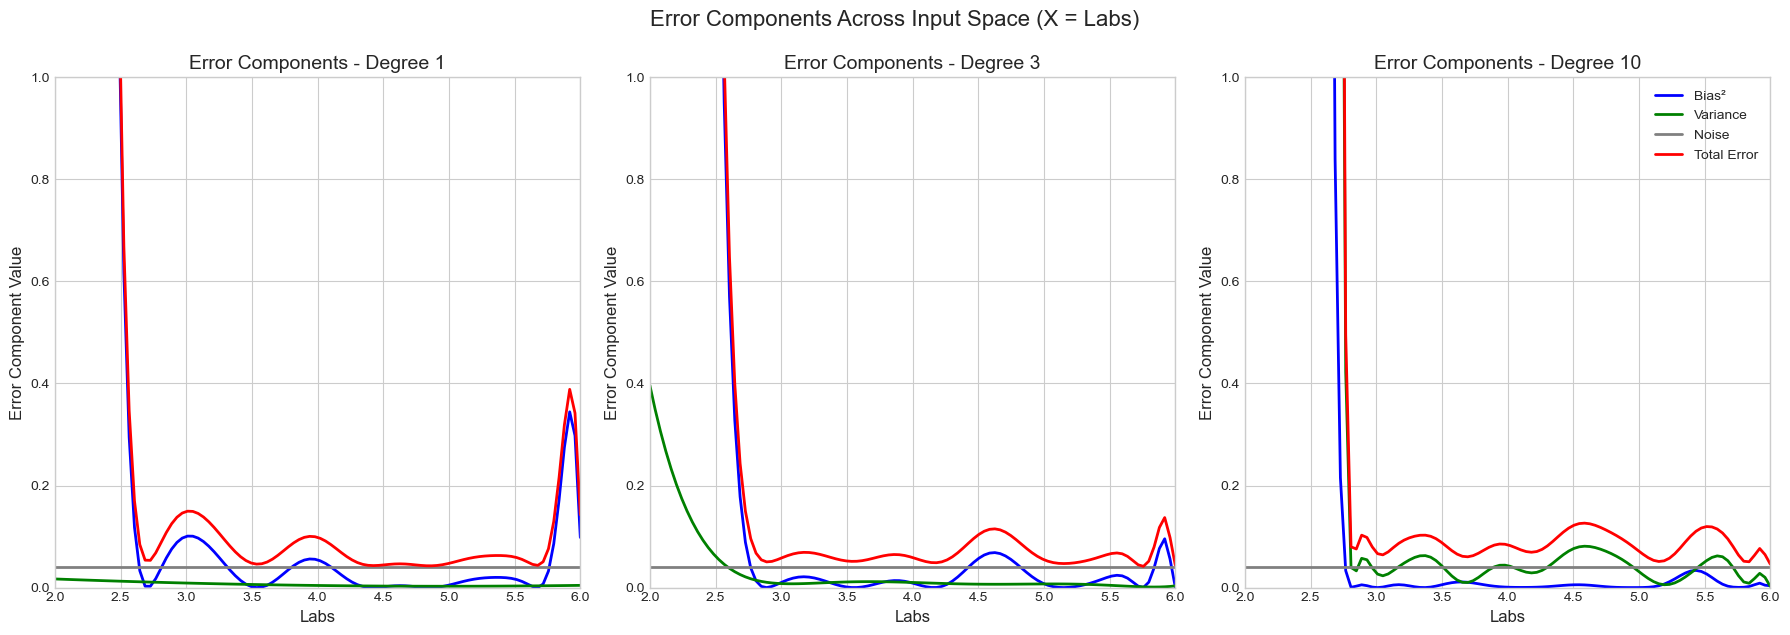

In [92]:
# Generate the error components by x value visualization (using Labs as input space)
%matplotlib inline
fig3, error_comp_axes = visualize_error_components_by_x(df_aug, degrees=[1, 3, 10], num_samples=10)

# Save figure
fig3.savefig('error_components_labs.png', dpi=300, bbox_inches='tight')
print("Saved figure as 'error_components_labs.png'")

And the plot above shows the bias, variance, and noise level, for each test data sample. Separate plots are given for polynimial degree 1, 3, and 10. 

Text(0.5, 1.05, 'Error Components with Lower Noise Variance (0.02)')

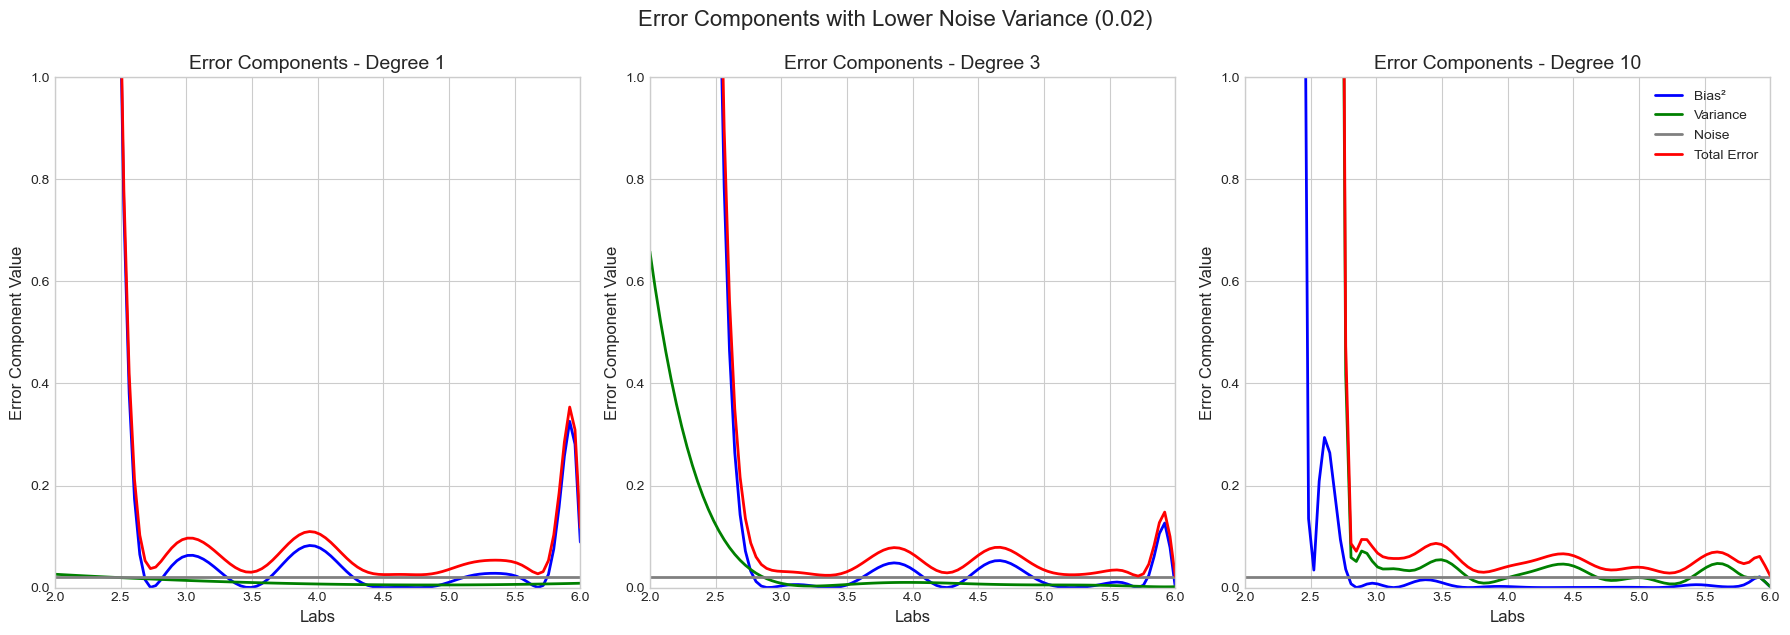

In [93]:
# Try different noise variance values
fig4, _ = visualize_error_components_by_x(df_aug, degrees=[1, 3, 10], num_samples=10, noise_var=0.02)
plt.suptitle('Error Components with Lower Noise Variance (0.02)', fontsize=16, y=1.05)

In [95]:
def plot_bias_variance_with_training_error(df_aug, max_degree=10, num_samples=10, test_size=0.3):
    """
    Plot bias, variance, training error, and test error as a function of model complexity.
    
    Parameters:
    - df_aug: Augmented DataFrame containing the features and target
    - max_degree: Maximum polynomial degree to evaluate
    - num_samples: Number of different training samples to use
    - test_size: Proportion of data to use for testing
    """
    # Use Labs as feature
    X = df_aug[['Labs']]
    y = df_aug['Final']
    
    # Create a common test set
    X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    # Arrays to store results
    degrees = list(range(1, max_degree + 1))
    bias_values = []
    variance_values = []
    total_error_values = []
    train_error_values = []  # Added training error
    
    # Calculate metrics for each degree
    for degree in degrees:
        # Store predictions for all samples
        all_train_predictions = np.zeros((num_samples, len(X_train_full)))  # Added for training data
        all_test_predictions = np.zeros((num_samples, len(X_test)))
        
        # Train multiple models with different samplings
        for j in range(num_samples):
            # Sample from training data with replacement
            indices = np.random.choice(len(X_train_full), size=len(X_train_full), replace=True)
            X_sample = X_train_full.iloc[indices]
            y_sample = y_train_full.iloc[indices]
            
            # Create and train model
            model = make_pipeline(
                PolynomialFeatures(degree=degree),
                LinearRegression()
            )
            model.fit(X_sample, y_sample)
            
            # Predict on both training and test data
            train_pred = model.predict(X_train_full)  # Added for training error
            test_pred = model.predict(X_test)
            all_train_predictions[j] = train_pred  # Added for training error
            all_test_predictions[j] = test_pred
            
        # Calculate average predictions
        avg_train_predictions = np.mean(all_train_predictions, axis=0)  # Added for training error
        avg_test_predictions = np.mean(all_test_predictions, axis=0)
        
        # Calculate training error
        train_mse = np.mean((avg_train_predictions - y_train_full.values) ** 2)
        train_error_values.append(train_mse)
        
        # Calculate bias^2
        bias_squared = np.mean((avg_test_predictions - y_test.values) ** 2)
        bias_values.append(bias_squared)
        
        # Calculate variance
        variance = np.mean(np.var(all_test_predictions, axis=0))
        variance_values.append(variance)
        
        # Calculate test error
        total_error = bias_squared + variance
        total_error_values.append(total_error)
    
    # Create plot
    plt.figure(figsize=(10, 6))
    plt.plot(degrees, bias_values, 'o-', color='blue', linewidth=2, label='Bias²')
    plt.plot(degrees, variance_values, 'o-', color='green', linewidth=2, label='Variance')
    plt.plot(degrees, total_error_values, 'o-', color='red', linewidth=2, label='Test Error')
    plt.plot(degrees, train_error_values, 'o--', color='purple', linewidth=2, label='Training Error')
    
    # Highlight specific degrees
    highlight_degrees = [1, 3, 10]
    for deg in highlight_degrees:
        idx = deg - 1
        plt.scatter(deg, bias_values[idx], color='blue', s=100, zorder=5)
        plt.scatter(deg, variance_values[idx], color='green', s=100, zorder=5)
        plt.scatter(deg, total_error_values[idx], color='red', s=100, zorder=5)
        plt.scatter(deg, train_error_values[idx], color='purple', s=100, zorder=5)
    
    plt.xlabel('Polynomial Degree (Model Complexity)', fontsize=14)
    plt.ylabel('Error', fontsize=14)
    plt.title('Bias-Variance Tradeoff with Training and Test Error', fontsize=16)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)
    
    # Set y-axis limit to a reasonable value based on data
    max_error = max(max(bias_values), max(variance_values), 
                    max(total_error_values), max(train_error_values))
    plt.ylim(0, min(max_error * 1.1, 2.0))  # Cap at 2.0 to keep visualization clean
    
    return plt.gcf()

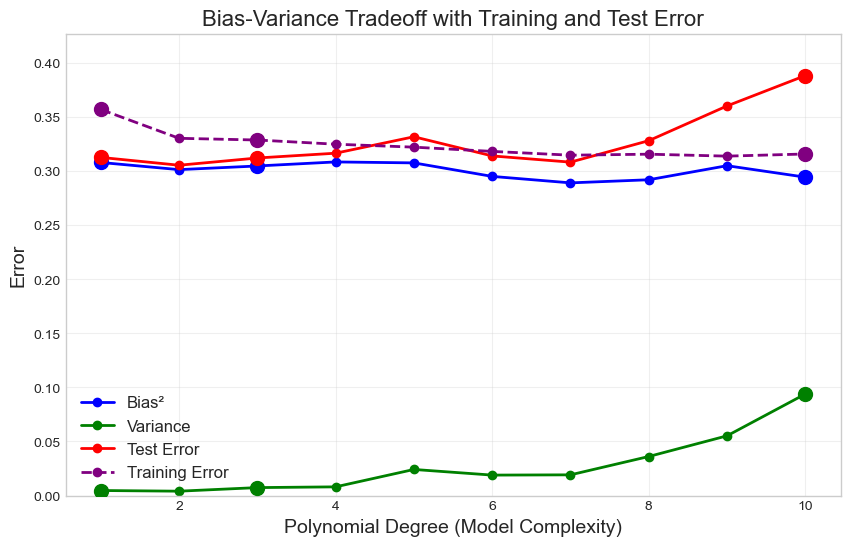

In [96]:
# Generate the bias-variance curve with training error
fig4 = plot_bias_variance_with_training_error(df_aug, max_degree=10, num_samples=10)
plt.show()